In [1]:
from __future__ import print_function, division
from builtins import range, input

import os, sys

from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

try:
  import tensorflow.keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

import tensorflow as tf
# import torch

gpus = tf.config.experimental.list_physical_devices('GPU')
if not gpus:
    print("No GPUs found")
else:
    print(f"GPUs available: {gpus}")
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-09-18 15:03:55.329739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 15:03:55.338242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 15:03:55.340835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 15:03:55.347610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 15:03:56.123402: W tensorflow/compiler/tf2

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


I0000 00:00:1726664637.263709  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726664637.294809  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726664637.294847  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 3000  # Number of epochs to train for.
LATENT_DIM = 512  # Latent dimensionality of the encoding space.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
LEARNING_RATE = 0.0001

In [3]:
RUN_NAME = f'Em{EMBEDDING_DIM}_Bat{BATCH_SIZE}_Epo{EPOCHS}'

# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

PATH_DATA_ROOT = 'Input'
PATH_SAVEMODEL_ROOT = os.path.join('Output/%s' % RUN_NAME)

PATH_FILE_TRAIN = os.path.join('%s/WikiQA-train.tsv' % PATH_DATA_ROOT)
PATH_FILE_TEST = os.path.join('%s/WikiQA-test.tsv' % PATH_DATA_ROOT)
PATH_FILE_DEV = os.path.join('%s/WikiQA-dev.tsv' % PATH_DATA_ROOT)

PATH_EMBEDDING = f'{PATH_DATA_ROOT}/glove.6B.{EMBEDDING_DIM}d.txt'

PATH_TOKENIZER_OUTPUT = os.path.join('%s/tokenizer_output.pickle' % PATH_SAVEMODEL_ROOT)
PATH_TOKENIZER_INPUT = os.path.join('%s/tokenizer_input.pickle' % PATH_SAVEMODEL_ROOT)

PATH_MODEL= os.path.join('%s/s2s.h5' % PATH_SAVEMODEL_ROOT)
PATH_ENCODER_MODEL = os.path.join('%s/encoder_model.h5' % PATH_SAVEMODEL_ROOT)
PATH_DECODER_MODEL = os.path.join('%s/decoder_model.h5' % PATH_SAVEMODEL_ROOT)

PATH_SEQUENCE_FILE = os.path.join('%s/input_sequences.pkl' % PATH_SAVEMODEL_ROOT)
PATH_TARGET_SEQUENCE_FILE = os.path.join('%s/target_sequences.pkl' % PATH_SAVEMODEL_ROOT)

if not os.path.exists(PATH_SAVEMODEL_ROOT):
    os.makedirs(PATH_SAVEMODEL_ROOT)
    print(f'Folder has been created: {PATH_SAVEMODEL_ROOT}')
else:
    print(f"Folder already exists: {PATH_SAVEMODEL_ROOT}")

Folder already exists: Output/Em100_Bat64_Epo3000


In [4]:
def filer_data_label0(data_frame):
    filtered_data_frame = data_frame[data_frame['Label'] == 1]
    return filtered_data_frame

def filter_data_drop_na(data_frame, col):
    filtered_data_frame = data_frame.dropna(subset=col)
    return filtered_data_frame

def drop_not_use_columns(data_frame):
    data_frame.drop(columns=['QuestionID'], inplace=True)
    data_frame.drop(columns=['DocumentID'], inplace=True)
    data_frame.drop(columns=['DocumentTitle'], inplace=True)
    data_frame.drop(columns=['SentenceID'], inplace=True)
    return data_frame

def drop_duplicate_rows(data_frame):
    data_frame.drop_duplicates(subset='Question')
    return data_frame

def data_cleaning(data_frame):
    cleaned_data_frame = filer_data_label0(data_frame)
    cleaned_data_frame = filter_data_drop_na(cleaned_data_frame, 'Sentence')
    cleaned_data_frame = drop_not_use_columns(cleaned_data_frame)
    cleaned_data_frame = drop_duplicate_rows(cleaned_data_frame)
    return cleaned_data_frame

In [5]:
data_train = pd.read_csv(PATH_FILE_TRAIN, sep='\t')
data_test = pd.read_csv(PATH_FILE_TEST, sep='\t')
data_train

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0
...,...,...,...,...,...,...,...
20342,Q3043,what is section eight housing,D2807,Section 8 (housing),D2807-8,A tenant who leaves a subsidized project will ...,0
20343,Q3043,what is section eight housing,D2807,Section 8 (housing),D2807-9,The United States Department of Housing and Ur...,0
20344,Q3044,what is the main type of restaurant,D2808,Category:Types of restaurants,D2808-0,Restaurants categorized by type and informatio...,0
20345,Q3046,what is us dollar worth based on,D2810,History of the United States dollar,D2810-0,U.S. Federal Reserve notes in the mid-1990s,0


In [6]:
data_train_filtered = data_cleaning(data_train)
data_test_filtered = data_cleaning(data_train)
data_train_filtered

,Question,Sentence,Label
3,how are glacier caves formed?,A glacier cave is a cave formed within the ice...,1
75,how much is 1 tablespoon of water,This tablespoon has a capacity of about 15 mL.,1
83,how much is 1 tablespoon of water,In the USA one tablespoon (measurement unit) i...,1
84,how much is 1 tablespoon of water,In Australia one tablespoon (measurement unit)...,1
98,how much are the harry potter movies worth,The series also originated much tie-in merchan...,1
...,...,...,...
20292,What is an economic feature?,"At the turn of the 21st century, the expanding...",1
20307,what is the average american income,"U.S. median household income fell from $51,144...",1
20325,When was Apple Computer founded,"The company was founded on April 1, 1976, and ...",1
20335,what is section eight housing,"Section 8 of the Housing Act of 1937 (), often...",1


In [7]:
# 리스트 초기화
input_texts = []
target_texts = []
target_texts_inputs = []

for index, row in data_train_filtered.iterrows():
    
    input_text = row['Question'].strip()
    target = row['Sentence'].strip()

    # 목표 텍스트 생성
    target_text = target + ' <eos>'  
    target_text_input = '<sos> ' + target  

    # 각 리스트에 저장
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)

# 결과 출력
print("num samples:", len(input_texts))

num samples: 1039


In [8]:
# 각 요소의 단어 수를 계산하여 리스트에 저장
target_texts_inputs_word_count = [len(text.split()) for text in target_texts_inputs]

# 결과 확인
print(max(target_texts_inputs_word_count))

167


In [9]:
words_freq ={}

for words in set(target_texts_inputs_word_count):
    if words not in words_freq:
        words_freq[words] = 1
    else:
        words_freq[words] = words_freq[words] +1

print(words_freq)

{2: 1, 3: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 60: 1, 61: 1, 62: 1, 63: 1, 65: 1, 67: 1, 69: 1, 70: 1, 167: 1, 74: 1, 77: 1, 78: 1}


In [10]:
data_train_filtered.to_csv(os.path.join('%s/train_filtered.csv' % PATH_SAVEMODEL_ROOT))
data_test_filtered.to_csv(os.path.join('%s/test_filtered.csv' % PATH_SAVEMODEL_ROOT))

max_word_count = max(words_freq.keys())
print(max_word_count)

167


In [11]:
tokenizer_inputs = Tokenizer(num_words=20000)
tokenizer_inputs.fit_on_texts(input_texts)

input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

import pickle
with open(PATH_TOKENIZER_INPUT, 'wb') as handle:
    pickle.dump(tokenizer_inputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(input_sequences)

[[5, 8, 658, 659, 101], [5, 35, 2, 78, 187, 6, 79], [5, 35, 2, 78, 187, 6, 79], [5, 35, 2, 78, 187, 6, 79], [5, 35, 8, 3, 102, 134, 660, 188], [5, 9, 661, 189, 305], [5, 8, 662, 20, 663, 664, 20, 665], [5, 13, 666, 306, 51], [5, 8, 667, 668, 669, 190], [5, 307, 103, 80, 670, 16, 307, 671], [5, 44, 14, 672, 673, 308, 3, 674], [5, 104, 14, 306, 675, 676], [5, 35, 2, 677, 678, 188], [5, 135, 2, 679, 680], [5, 44, 2, 681, 682, 3, 309], [5, 44, 2, 3, 136, 683, 684], [5, 104, 14, 191, 81, 9, 36], [5, 44, 137, 3, 685, 686, 11, 687], [5, 8, 3, 6, 688, 4, 689, 690, 691], [5, 15, 310, 6, 3, 33], [5, 44, 2, 692, 693], [5, 8, 192, 193, 311], [5, 8, 192, 193, 311], [1, 312, 18, 3, 313, 314, 315, 6, 316], [1, 312, 18, 3, 313, 314, 315, 6, 316], [1, 13, 694, 695, 17, 317, 38], [1, 52, 8, 696, 3, 697, 698], [5, 13, 699, 700, 701, 51], [5, 15, 138, 702, 30, 703, 22, 318], [5, 17, 194, 195, 196, 197, 198], [5, 17, 194, 195, 196, 197, 198], [5, 17, 194, 195, 196, 197, 198], [1, 13, 3, 704, 82, 18, 705, 3

In [12]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 1935 unique input tokens.


In [13]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=20000, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [14]:
# Tokenizer 저장
import pickle
with open(PATH_TOKENIZER_OUTPUT, 'wb') as handle:
    pickle.dump(tokenizer_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

max_len_input = max(len(s) for s in input_sequences)
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

Found 8462 unique output tokens.
encoder_inputs.shape: (1039, 19)
encoder_inputs[0]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   8 658 659
 101]
decoder_inputs[0]: [   9    4 1481  941    7    4  941  176  116    1 1482    2    4 1481
   11    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

In [15]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(PATH_EMBEDDING, encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [16]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  trainable=True
)

##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
x= Bidirectional(LSTM(LATENT_DIM, return_sequences=True))(x)
encoder_outputs, state_h, state_c = LSTM(
    LATENT_DIM, return_state=True)(x)

# Concatenate forward and backward states

encoder_states = [state_h, state_c]

# Decoder
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Add Dropout to prevent overfitting
decoder_outputs = Dropout(0.5)(decoder_outputs)

# Final dense layer to predict words
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create model
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

optimizer = Adam(learning_rate=LEARNING_RATE)  # 학습률 조정

def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
    # y_true를 int32로 명시적으로 변환
    y_true = K.cast(y_true, dtype='int32')

    pred = K.argmax(y_pred, axis=-1)  # 예측된 값에서 가장 높은 확률의 인덱스 추출
    pred = K.cast(pred, dtype='int32')  # pred도 int32로 변환
    correct = K.cast(K.equal(y_true, pred), dtype='float32')

    # 패딩 값 0을 제외한 부분에 대한 마스킹
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total



# encoder_inputs, decoder_inputs, decoder_targets을 int32로 변환
encoder_inputs = np.array(encoder_inputs, dtype='int32')
decoder_inputs = np.array(decoder_inputs, dtype='int32')
decoder_targets = np.array(decoder_targets, dtype='int32')
# embedding_matrix는 float32로 유지
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype='float32')


Filling pre-trained embeddings...


/home/woong/myenv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1726664640.958969  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726664640.959049  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726664640.959088  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726664641.087391  649689 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726664641.087430  649689 

In [17]:
# 모델 컴파일 시 custom loss 대신 SparseCategoricalCrossentropy 사용
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [18]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience  # 얼리스토핑에 사용할 patience
        self.wait = 0
        self.best_val_loss = float('inf')
        self.stop_training_flag = False

    def on_epoch_end(self, epoch, logs=None):
        current_acc = logs.get('acc')
        current_val_loss = logs.get('val_loss')
        current_loss = logs.get('loss')
        
        if current_val_loss > self.best_val_loss or current_loss > self.best_val_loss:
            self.wait += 1
            print(f"Early stopping condition met. Waiting: {self.wait}/{self.patience}")
            
            if self.wait >= self.patience:
                self.stop_training_flag = True
                self.model.stop_training = True  # 학습 중단
        else:
            # 더 나은 val_loss 또는 loss가 나오면 best_val_loss 갱신 및 wait 리셋
            self.best_val_loss = min(current_val_loss, current_loss)
            self.wait = 0


In [19]:
early_stopping_callback = CustomEarlyStopping(patience=10)

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.1,
  callbacks=[early_stopping_callback]
)

Epoch 1/3000


2024-09-18 15:04:03.419445: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5978 - loss: 8.9754 - val_accuracy: 0.8341 - val_loss: 8.3876
Epoch 2/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8358 - loss: 7.5152 - val_accuracy: 0.8316 - val_loss: 5.0098
Epoch 3/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8340 - loss: 4.3981 - val_accuracy: 0.8316 - val_loss: 2.6000
Epoch 4/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8342 - loss: 2.2703 - val_accuracy: 0.8316 - val_loss: 1.6579
Epoch 5/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8339 - loss: 1.6098 - val_accuracy: 0.8316 - val_loss: 1.4900
Epoch 6/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8335 - loss: 1.4658 - val_accuracy: 0.8316 - val_loss: 1.4158
Epoch 7/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8328 - loss: 1.4056 - val_accuracy: 0.8316 - val_loss: 1.3832
Epoch 8/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8349 - loss: 1.3563 - val_accuracy: 0.8316 

In [20]:

# 가중치 비교
original_weights = model.get_weights()

# 모델을 저장
model.save(PATH_MODEL)

# 모델을 불러옴
model_loaded = load_model(PATH_MODEL, custom_objects={'custom_loss': custom_loss, 'acc': acc})

# 불러온 모델의 가중치
loaded_weights = model_loaded.get_weights()


In [21]:
# 가중치 비교
for original, loaded in zip(original_weights, loaded_weights):
    if np.array_equal(original, loaded):
        print("가중치 일치")
    else:
        print("가중치 불일치")

가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치
가중치 일치


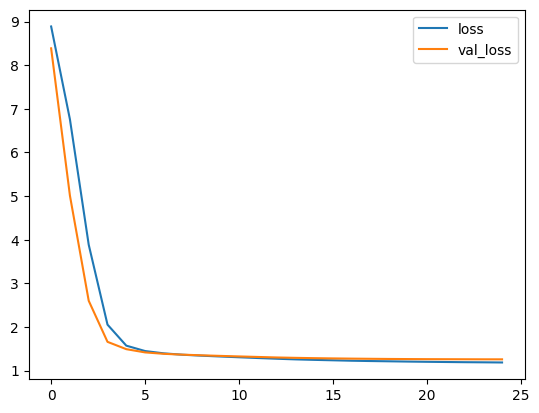

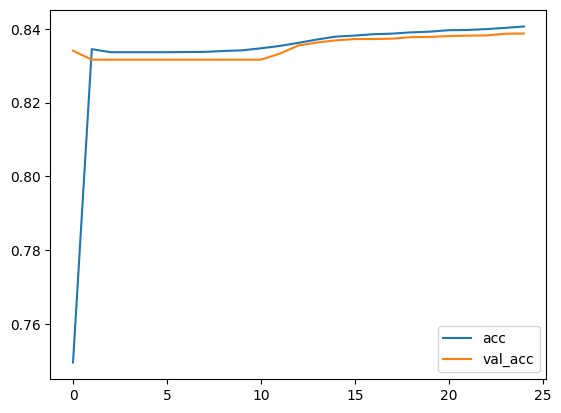

d


In [24]:

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
print('d')


In [30]:


##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
  print('Input Sequences: ', input_seq)
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']
  print('Target Sequences: ', target_seq)
  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    
    print('Output Tokens: ', output_tokens)
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next wordgfhjfghj
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [26]:

encoder_model.save(PATH_ENCODER_MODEL)
decoder_model.save(PATH_DECODER_MODEL)

In [31]:
# Do some test translations
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)
print('-')
print('Input:', input_texts[i])
print('Translation:', translation)

Input Sequences:  [[  0   0   0   0   0   0   0   0   0   0   0   0   0   5  88 845 846   8
  153]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Target Sequences:  [[9.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Output Tokens:  [[[1.31606525e-02 1.14762664e-01 2.70915702e-02 ... 1.36199296e-05
   1.08727445e-05 8.01032547e-06]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Output Tokens:  [[[8.8965222e-03 7.6641150e-02 2.2780219e-02 ... 1.8010574e-05
   1.4980042e-05 1.1612610e-05]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Output Tokens:  [[[8.2620932e-03 6.5810353e-02 2.2007747e-02 ... 1.9189007e-05
   1.6481852e-05 1.2895747e-05]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Output Tokens:  [[[8.2875928e-03 6.1595108e-02 2.2659479e-02 ... 1.9279416e-05
   1.6810129e-05 1.3212479e-05]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Output Tokens:  [[[8.5541075e-03 5.9410557e-02 2.3884255e-02 ... 1.9061827e-05
   1.6601971e-05 1.3247091e-05]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Output Tokens:  [[[8.8899033e-03 5.7